In [1]:
# Basic import
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy, copy
from scipy.stats import norm
import pdb
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Dot, Concatenate
from tensorflow.keras.models import Model
tf.config.experimental_run_functions_eagerly(True)
print(tf.__version__)

2.0.0


# Environment

In [2]:
class Environment:
    def __init__(self, nb_films, nb_users, 
                 context_size = 2,
                 displayed_users_embedding_size = 2, #used for the features vector
                 displayed_games_embedding_size = 2, #used for the features vector
                 noise_size = 3,
                 rating_probability = 0.5,
                 std_dev_playtime = 0.15,
                 refund_threshold = 0.1,
                 seed=None):     
        self._rng = np.random.RandomState(seed)
        self._rating_probability = rating_probability 
        self._std_dev_playtime = std_dev_playtime
        self._refund_threshold = refund_threshold
        #-------------------------------------------------------#
        self._nb_games = nb_games
        self._nb_users = nb_users
        self._p = context_size # size of user, size of game
        self._displayed_users_embedding_size = displayed_users_embedding_size
        self._displayed_games_embedding_size = displayed_games_embedding_size
        self._noise_size = noise_size
        #-------------------------------------------------------
        self.user_mean = np.ones(self._p)
        self.user_var = np.ones(self._p)
        self.game_mean = np.ones(self._p)
        self.game_var = np.ones(self._p)
        #-------------------------------------------------------#
        self.finish = False # True = all games have been played
    
    def step(self):
        if self.finish == True or self._available_games.sum() == 0: 
            # all players played all games
            self.finish = True
            print("All games played reset the environment")
            return 0, 0, self.finish
        
        user = self.get_next_user() # pick a user
        available_games = np.where(self._available_games[user] == 1)[0]
        optimal_reward = np.max(self._reward_matrix[user,available_games])
        return user, available_games, optimal_reward, self.finish
    
    def get_next_user(self):
        user = self._rng.randint(0, self._nb_users)
        if np.sum(self._available_games[user,:]) > 0: 
            # still some games to play for user
            return user
        else: 
            # all games played for the current user
            # find a random player between the ones who have some games left to play
            row,cols = np.where(self._available_games == 1)
            return self._rng.choice(row)
    
    def update(self, user, game):
        reward = self._reward_matrix[user, game]
        rated = bool(self._rated[user, game])
        self._available_games[user, game] = 0
        return reward, rated
    
    def reset(self):
        self.finish = False
        self._users = self._rng.normal(loc=self.user_mean,
                                                scale=self.user_var,
                                                size=(self._nb_users, self._p))
        self._games = self._rng.normal(loc=self.game_mean,
                                                scale=self.game_var,
                                                size=(self._nb_games, self._p))
        
        z_mean = self.user_mean.dot(self.game_mean)
        z_var = self.user_var.dot(self.game_var) + self.user_var.dot(np.square(self.game_mean)) + \
                self.game_var.dot(np.square(self.user_mean))
        z = norm(z_mean, np.sqrt(z_var))
        self.z_cut_points = z.ppf([0.2, 0.4, 0.6, 0.8]) # buckets
        
        self._available_games = np.ones((nb_users, nb_games))
        # rating generation based on (user ∙ game)
        self._rating_matrix = np.zeros((nb_users, nb_games))     
        for i in range(self._rating_matrix.shape[0]):
            for j in range(self._rating_matrix.shape[1]):
                real_score = self._users[i].dot(self._games[j])
                self._rating_matrix[i, j] = np.searchsorted(self.z_cut_points, real_score) / 4
        # playtime generation
        # for simulation purposes, such playtime (always > 0) is based on the similarity 
        # between the user profile and the game (i.e. like a reward) + some noise
        # and some non-linear function (i.e. abs + clip)
        self._playtime_matrix = deepcopy(self._rating_matrix)
        self._playtime_matrix += self._rng.normal(loc = 0.0, scale = self._std_dev_playtime, size = (nb_users, nb_games))
        self._playtime_matrix = np.clip(np.abs(self._playtime_matrix), 0, 1)
        # reward matrix generation
        self._reward_matrix = np.zeros((nb_users, nb_games))
        self._rated = self._rng.binomial(1, self._rating_probability, size=(nb_users, nb_games))
        for i in range(self._reward_matrix.shape[0]):
            for j in range(self._reward_matrix.shape[1]):
                if self._playtime_matrix[i, j] < self._refund_threshold:
                    self._reward_matrix[i, j] = 0
                else:
                    if self._rated[i, j] == 1:
                        self._reward_matrix[i, j] = self._rating_matrix[i, j]
                    else:
                        self._reward_matrix[i, j] = self._playtime_matrix[i, j] / np.sum(self._playtime_matrix[i, :])
        users = deepcopy(self._users)
        return users

    def get_feature_vector(self, user, game):
        user_embedding = self._users[user]
        game_embedding = self._games[game]
        
        if self._displayed_users_embedding_size + self._displayed_games_embedding_size > 0:
            variables = np.array([user_embedding[:self._displayed_users_embedding_size],
                                  game_embedding[:self._displayed_games_embedding_size]])

            if self._noise_size > 0:
                noise = self._rng.normal(loc=np.ones(self._noise_size),
                                         scale=np.ones(self._noise_size),
                                         size=self._noise_size)
                
                variables = np.append(variables, noise)
                
        return variables
        
        
    def reset_seed(self, seed=None):
        self._rng = np.random.RandomState(seed)
        return

# Historical data generation

## Random agent

In [3]:
class RandomAgent:
    def __init__(self, seed = None):
        self._rng = np.random.RandomState(seed)
    
    def act(self, available_games):
        action = self._rng.choice(available_games)
        return action

## Experiment

In [4]:
# global parameters
nb_users = 50 # number of users in the context = 30
nb_games = 20 # number of games in the context = 10
context_size = 10 # number of different game categories = 2
agents = dict()

In [5]:
# creating the environment
env = Environment(nb_games,nb_users,context_size,seed=2020,rating_probability=0.4,std_dev_playtime=0.15)
env.reset() # reset and initilize the environment
prev_env = deepcopy(env)

In [6]:
# Creating the agent
agent = RandomAgent(2020)

In [7]:
# Running several trials
nb_iteration = 300 #how many trials
reward_matrix = np.zeros((nb_users, nb_games))
users = list()
games = list()
rewards = list()
for i in range(nb_iteration):
    user, available_games, _, finish = env.step()
    if finish:
        print("Maybe too many trial try to reduce and reset the environment")
        break
    choosen_game = agent.act(available_games)
    reward, rated = env.update(user, choosen_game)
    users.append(user)
    games.append(choosen_game)
    rewards.append(reward)
    reward_matrix[user, choosen_game] = reward
    print("user = {}, available games = {}, choosen_game = {}".format(user,available_games,choosen_game))
    print("reward = {}, rated = {}\n".format(reward, rated))
#print("reward matrix: \n", str(reward_matrix))

user = 12, available games = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], choosen_game = 0
reward = 0.014640942081329641, rated = False

user = 39, available games = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], choosen_game = 8
reward = 0.5, rated = True

user = 38, available games = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], choosen_game = 3
reward = 0.5, rated = True

user = 27, available games = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], choosen_game = 3
reward = 0.0307590213709722, rated = False

user = 37, available games = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], choosen_game = 3
reward = 0.0, rated = True

user = 45, available games = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], choosen_game = 7
reward = 0.08043371942319609, rated = False

user = 44, available games = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], choosen_game = 16
reward = 0.5, rat

# Embedding agent

## Regression model

In [8]:
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user, max_game):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user,
                                        input_length=1,
                                        name='user_embedding')
        self.game_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_game,
                                        input_length=1,
                                        name='game_embedding')
        self.flatten = Flatten()
        self.dot = Dot(axes=1)
        
    def call(self, inputs):
        user_inputs = inputs[0]
        game_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        game_vecs = self.flatten(self.game_embedding(game_inputs))
        
        y = self.dot([user_vecs, game_vecs])
        return y

## Deep regression model

In [9]:
class DeepRegressionModel(Model):

    def __init__(self, embedding_size, max_user, max_game):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user,
                                        input_length=1,
                                        name='user_embedding')
        self.game_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_game,
                                        input_length=1,
                                        name='game_embedding')
        
        self.flatten = Flatten()
        self.concat = Concatenate()
        
        self.dropout = Dropout(0.9)
        self.dense1 = Dense(16, activation="relu")
        self.dense2 = Dense(8, activation="tanh")
        
    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        game_inputs = inputs[1]
        feature_inputs = inputs[2]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        game_vecs = self.flatten(self.game_embedding(game_inputs))
        
        input_vecs = self.concat([user_vecs, game_vecs, self.flatten(feature_inputs)])
        
        y = self.dropout(input_vecs, training=training)
        y = self.dense1(y)
        y = self.dense2(y)
        
        return y

## Implementation

In [10]:
class EmbeddingAgent:
    def __init__(self, X, Y, deepRegression=False):
        if deepRegression:
            self._model = DeepRegressionModel(64, nb_users, nb_games)
        else:
            self._model = RegressionModel(64, nb_users, nb_games)
        self._model.compile(optimizer="adam", loss='mae')
        self._model.fit(X, Y,
                  batch_size=64, epochs=50, validation_split=0.1,
                  shuffle=True)
        self._user_embeddings = self._model.get_weights()[0]
        self._game_embeddings = self._model.get_weights()[1]
    
    def act(self, user, available_games):
        user_embedding = self._user_embeddings[user]
        dot_products = self._game_embeddings @ user_embedding
        user_embedding_norm = np.linalg.norm(user_embedding)
        all_item_norms = np.linalg.norm(self._game_embeddings, axis=1)
        norm_products = user_embedding_norm * all_item_norms
        sims = dot_products / (norm_products)
        sims = np.argsort(sims)[::-1]
        mask = np.in1d(sims, available_games)
        sims = sims[mask]
        return sims[0]

    def update(self, user, game, rating):
        pass

    def reset(self):
        pass

In [11]:
users = np.array(users)
games = np.array(games)
rewards = np.array(rewards)

agents["reg"] = EmbeddingAgent([users, games], rewards, deepRegression=False)

features = list()
for i in range(len(users)):
    features.append(env.get_feature_vector(users[i], games[i]))
features = np.float64(features)
agents["deep_reg"] = EmbeddingAgent([users, games, features], rewards, deepRegression=True)

Train on 270 samples, validate on 30 samples
Epoch 1/50
270/270 [==============================] - 0s 246us/sample - loss: 0.1815 - val_loss: 0.1441
Epoch 2/50
270/270 [==============================] - 0s 204us/sample - loss: 0.1788 - val_loss: 0.1442
Epoch 3/50
270/270 [==============================] - 0s 218us/sample - loss: 0.1766 - val_loss: 0.1442
Epoch 4/50
270/270 [==============================] - 0s 201us/sample - loss: 0.1745 - val_loss: 0.1443
Epoch 5/50
270/270 [==============================] - 0s 229us/sample - loss: 0.1724 - val_loss: 0.1442
Epoch 6/50
270/270 [==============================] - 0s 224us/sample - loss: 0.1703 - val_loss: 0.1441
Epoch 7/50
270/270 [==============================] - 0s 202us/sample - loss: 0.1679 - val_loss: 0.1438
Epoch 8/50
270/270 [==============================] - 0s 208us/sample - loss: 0.1654 - val_loss: 0.1434
Epoch 9/50
270/270 [==============================] - 0s 208us/sample - loss: 0.1627 - val_loss: 0.1427
Epoch 10/50
270/270

270/270 [==============================] - 0s 321us/sample - loss: 0.2528 - val_loss: 0.1882
Epoch 21/50
270/270 [==============================] - 0s 239us/sample - loss: 0.2656 - val_loss: 0.1839
Epoch 22/50
270/270 [==============================] - 0s 238us/sample - loss: 0.2618 - val_loss: 0.1815
Epoch 23/50
270/270 [==============================] - 0s 229us/sample - loss: 0.2451 - val_loss: 0.1803
Epoch 24/50
270/270 [==============================] - 0s 258us/sample - loss: 0.2492 - val_loss: 0.1792
Epoch 25/50
270/270 [==============================] - 0s 233us/sample - loss: 0.2374 - val_loss: 0.1761
Epoch 26/50
270/270 [==============================] - 0s 311us/sample - loss: 0.2347 - val_loss: 0.1736
Epoch 27/50
270/270 [==============================] - 0s 248us/sample - loss: 0.2342 - val_loss: 0.1714
Epoch 28/50
270/270 [==============================] - 0s 284us/sample - loss: 0.2308 - val_loss: 0.1697
Epoch 29/50
270/270 [==============================] - 0s 266us/sam

# User-based collaborative filtering agent

## Defining similarity between users

In [12]:
def similarity(ratings):
    # get the rewards for each user
    r_user = (ratings>0.0).sum(axis=1)
    
    # get the average reward for each user
    m_user = np.divide(ratings.sum(axis=1) , r_user, where=r_user!=0)
    
    # recentered rewards over user's average
    ratings_ctr = ratings.T - ((ratings.T!=0) * m_user)
    ratings_ctr = ratings_ctr.T
    
    # Gram's matrix
    sim = ratings_ctr.dot(ratings_ctr.T) 
    
    return sim

def phi(x):
    return np.maximum(x,0)

## Implementation

In [13]:
class CollaborativeFilteringAgent:
    def __init__(self, nb_users, nb_games, rating_matrix = None):
        self._nb_users = nb_users
        self._nb_games = nb_games
        self.reset(rating_matrix)
    
    def compute_matrix(self):
        sim = similarity(self._rating_matrix)
        numerator = phi(sim).dot(self._rating_matrix)
        denominator = phi(sim).dot(self._rating_matrix>0)
        self._pred_ratings = np.divide(numerator,denominator,where = denominator!=0)
    
    def update(self, user, game, rating):
        self._rating_matrix[user, game] = rating
        self.compute_matrix()
    
    def act(self, user, available_games):
        sims = self._pred_ratings[user]
        sims = np.argsort(sims)[::-1]
        mask = np.in1d(sims, available_games)
        sims = sims[mask]
        return sims[0]
    
    def reset(self, rating_matrix = None):
        if rating_matrix == None:
            self._rating_matrix = np.zeros((self._nb_users, self._nb_games))
        else:
            self._rating_matrix = rating_matrix
        self.compute_matrix()

In [14]:
agents["collab_filt"] = CollaborativeFilteringAgent(nb_users, nb_games)

# $\varepsilon$-greedy agent

In [15]:
def random_argmax(rng, list_):
    return rng.choice(np.argwhere(list_ == list_.max()).flatten())

class EpsilonGreedy:
    def __init__(self, nb_games, epsilon = 0.1, seed=None):
        self._nb_arms = nb_games
        self._epsilon = epsilon
        self.reset(seed)
        
    def act(self, _1, _2):
        if self._rng.random() < self._epsilon:
            action = self._rng.randint(self._nb_arms)
        else:
            action = random_argmax(self._rng, self._q)
        return action
        
    def update(self, _, action, reward):
        self._n[action] += 1
        self._q[action] += (reward - self._q[action])/self._n[action]
        
    def reset(self, seed=None):
        self._rng = np.random.RandomState(seed)
        self._q = np.zeros(self._nb_arms)
        self._n = np.zeros(self._nb_arms)

In [16]:
agents["eps"] = EpsilonGreedy(nb_games)

# UCB agent

In [17]:
class UCB:
    def __init__(self, nb_games, c=2., seed=None):
        self._nb_arms = nb_games
        self._c = c
        self.reset(seed)
        
    def act(self, _1, _2):
        if 0 in self._n:
            """ Play each action at least once. """
            action = self._rng.choice(np.where(self._n==0)[0])
        else:
            action = np.argmax(self._q + 
                               np.sqrt(self._c * np.log(self._t) / self._n))
            
        return action
        
    def update(self, _, action, reward):
        self._t += 1
        self._n[action] += 1
        self._q[action] += (reward - self._q[action])/self._n[action]

    def reset(self, seed=None):
        self._rng = np.random.RandomState(seed)
        self._q = np.zeros(self._nb_arms)
        self._n = np.zeros(self._nb_arms)
        self._t = 0

In [18]:
agents["ucb"] = UCB(nb_games)

# Thompson sampling agent

In [19]:
class BetaBernoulli(object):
    def __init__(self, a=1, b=1, prior=np.ones(2)):
        self.a = a
        self.b = b
        self.n = copy(prior)

    def update(self, reward):
        self.n[int(reward)] += 1

    def sample(self, np_random):
        return np_random.beta(self.a + self.n[1], self.b + self.n[0])

class ThompsonSampling:
    def __init__(self, nb_games, dist=BetaBernoulli, seed=None):
        self._nb_arms = nb_games
        self.reset(seed, dist)
        
    def act(self, _1, _2):
        sample = np.array([self._posterior[i].sample(self._rng)
                           for i in range(self._nb_arms)])
        action = np.argmax(sample)
        return action
        
    def update(self, _, action, reward):
        self._posterior[action].update(reward)
        
    def reset(self, seed=None, dist=BetaBernoulli):
        self._rng = np.random.RandomState(seed)
        self._posterior = [dist() for i in range(self._nb_arms)]

In [20]:
agents["thompson"] = ThompsonSampling(nb_games)

# SVD++ agent

In [21]:
from surprise import SVDpp, Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
import pandas as pd

class SVD_pp:
    def __init__(self, X, Y, nb_games):
        self._users = X[0]
        self._games = X[1]
        self._rewards = Y
        self._nb_games = nb_games
        df = pd.DataFrame(self._games, columns=['games'])
        df['users'] = self._users
        df['rewards'] = self._rewards
        reader = Reader(rating_scale=(0, 1))
        self._data = Dataset.load_from_df(df[['users', 'games', 'rewards']], reader)
        self._trainset = self._data.build_full_trainset()
        self.reset()
        
    def update(self, user, game, rating):
        pass
    
    def act(self, user, available_games):
        rewards = list()
        for i in range(self._nb_games):
            rewards.append(self._svd_pp.predict(user, i).est)
        
        sorted_rewards = np.argsort(rewards)[::-1]
        mask = np.in1d(sorted_rewards, available_games)
        sorted_rewards = sorted_rewards[mask]
        return sorted_rewards[0]
    
    def reset(self):       
        param_grid = {'n_epochs': [5, 10, 50, 100], 
                      'lr_all': [0.002, 0.005, 0.007],
                      'reg_all': [0.02, 0.4, 0.6]}
        gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
        gs.fit(self._data)
        best_predictor = gs.best_estimator['rmse']
        
        self._svd_pp = best_predictor.fit(self._trainset)

In [22]:
agents['svd_pp'] = SVD_pp([users, games], rewards, nb_games)

# Measuring performances

In [23]:
empty_history = True
if not empty_history:
    prev_env = deepcopy(env)

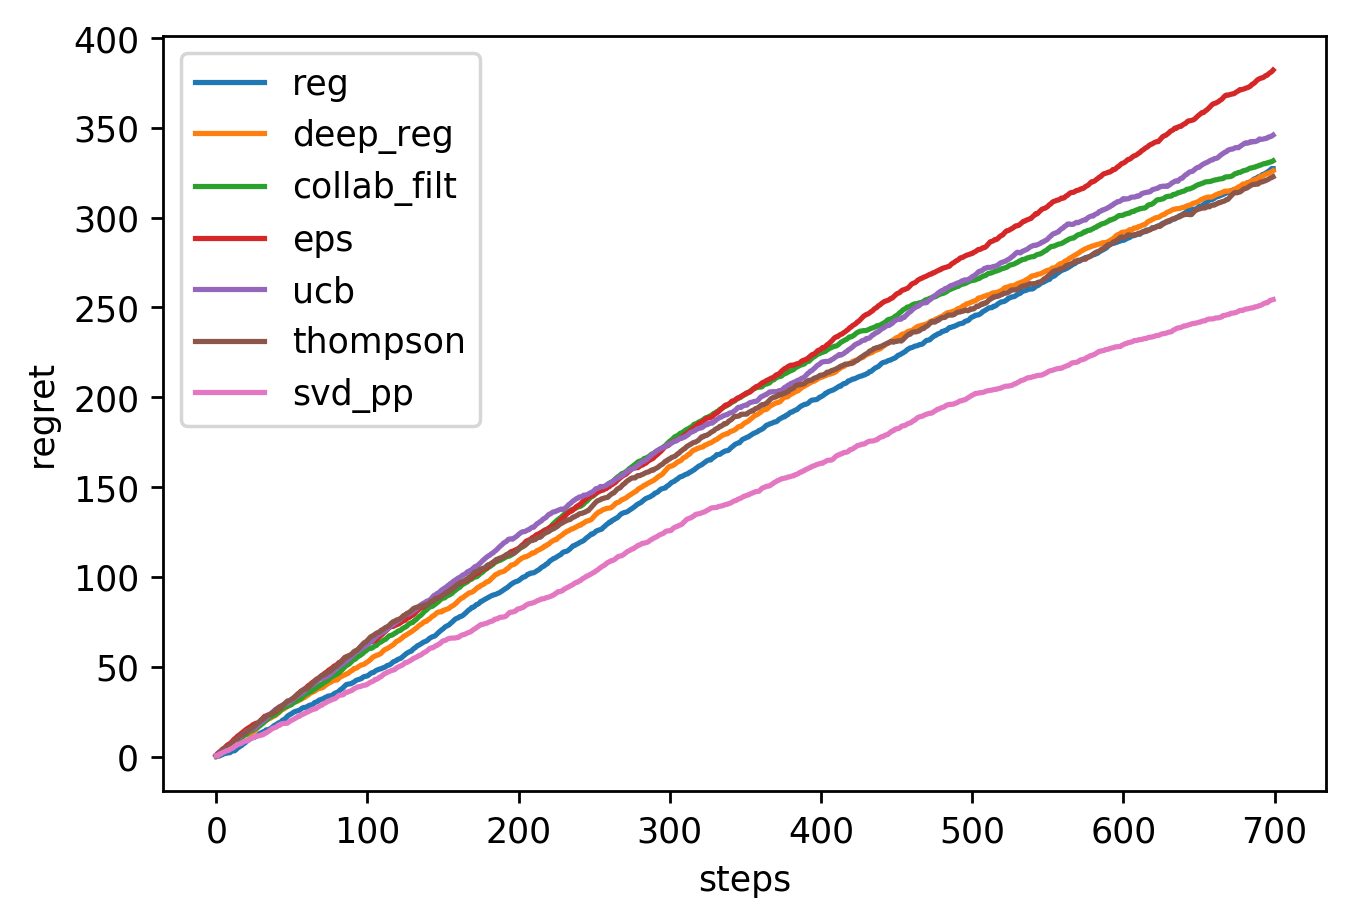

In [24]:
nb_iteration = 700
nb_exp = 2

plt.figure(dpi=250)
for name_agent in agents:
    agent = agents[name_agent]
    regret = np.zeros(nb_exp)
    cum_regret = np.zeros((nb_exp, nb_iteration))

    for t in range(nb_exp):
        env = deepcopy(prev_env)
        env.reset_seed()
        regrets = np.zeros(nb_iteration)
        for i in range(nb_iteration):
            user, available_games, optimal_reward, finish = env.step()
            if finish:
                print("Maybe too many trial try to reduce and reset the environment")
                break
            choosen_game = agent.act(user, available_games)
            reward, _ = env.update(user, choosen_game)
            agent.update(user, choosen_game, reward)
            regrets[i] = optimal_reward - reward
        agent.reset()
        cum_regret[t] = np.cumsum(regrets)
        regret[t] = np.sum(regrets)
    plt.plot(cum_regret.mean(axis=0), label=name_agent)
plt.xlabel('steps')
plt.ylabel('regret')
plt.legend()    
plt.show()